In [4]:
from finvizfinance.screener.overview import Overview
import pandas as pd
from finvizfinance.quote import finvizfinance
import yfinance as yf
import numpy as np
import pickle
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [5]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d} ({p:.2f}%)'.format(p=pct,v=val)
    return my_autopct

**Disclaimer:** All comments and explanations in this notebook are provided in English to maintain readability and consistency. If you have any questions or need further clarification, please feel free to ask.

# Introduction

My approach to trading is based on three fundamental pillars:
1. Specialization.
2. Long-term positive expected value dynamics.
3. Continuous updating of the statistics related to these dynamics.

In this notebook, I will use Python and some of its libraries to analyze the statistics of a specific dynamic.

# Dynamic

In this case, I am interested in stocks with:

- Minimum Gap >= 70%
- Open Price >= $3
- Pre-Market Volume >= 5M
- Total Daily Volume >= 25M
- Market Cap <= 500M
- Float >= 1M

# Question

In this scenario, how many times does the price of a stock close below the open?

Before addressing this question, it is advisable to gather some data and perform some data manipulation.

I will use the following libraries for this purpose:

- finvizfinance
- yfinance

Using finvizfinance, I will obtain the stock tickers that meet the market cap and float conditions, while yfinance will allow me to download historical data such as prices, volumes, opens, etc.

In [129]:
foverview = Overview()

In [130]:
foverview.get_filters()

['Exchange',
 'Index',
 'Sector',
 'Industry',
 'Country',
 'Market Cap.',
 'P/E',
 'Forward P/E',
 'PEG',
 'P/S',
 'P/B',
 'Price/Cash',
 'Price/Free Cash Flow',
 'EPS growththis year',
 'EPS growthnext year',
 'EPS growthpast 5 years',
 'EPS growthnext 5 years',
 'Sales growthpast 5 years',
 'EPS growthqtr over qtr',
 'Sales growthqtr over qtr',
 'Dividend Yield',
 'Return on Assets',
 'Return on Equity',
 'Return on Investment',
 'Current Ratio',
 'Quick Ratio',
 'LT Debt/Equity',
 'Debt/Equity',
 'Gross Margin',
 'Operating Margin',
 'Net Profit Margin',
 'Payout Ratio',
 'InsiderOwnership',
 'InsiderTransactions',
 'InstitutionalOwnership',
 'InstitutionalTransactions',
 'Float Short',
 'Analyst Recom.',
 'Option/Short',
 'Earnings Date',
 'Performance',
 'Performance 2',
 'Volatility',
 'RSI (14)',
 'Gap',
 '20-Day Simple Moving Average',
 '50-Day Simple Moving Average',
 '200-Day Simple Moving Average',
 'Change',
 'Change from Open',
 '20-Day High/Low',
 '50-Day High/Low',
 '52

# Filter

I'm only interested in stocks that have at least 1M in float, as this reduces the chances that short sellers might get trapped and have to cover their positions.

In [131]:
filters_dict = {'Float' :'Over 1M'}
foverview.set_filter(filters_dict=filters_dict)

In [132]:
df = foverview.screener_view()
df.head()

KeyboardInterrupt: 

Export the dataframe

In [6]:
df.to_csv('finvizfull.csv', index=False)

NameError: name 'df' is not defined

Import the dataframe

In [7]:
file_path='finvizfull.csv'
df = pd.read_csv(file_path)

In [8]:
df

,Ticker\n\n,Company,Sector,Industry,Country,Market Cap,P/E,Price,Change,Volume
0,A,"Agilent Technologies, Inc.",Healthcare,Diagnostics & Research,USA,3.547000e+10,31.94,121.91,0.0069,840682.0
1,AA,Alcoa Corporation,Basic Materials,Aluminum,USA,5.370000e+09,NaN,31.10,0.0339,5973963.0
2,AAC,Ares Acquisition Corporation,Financial,Shell Companies,USA,7.548200e+08,NaN,10.69,0.0000,29644.0
3,AACG,ATA Creativity Global,Consumer Defensive,Education & Training Services,China,3.920000e+07,NaN,1.26,0.0161,2867.0
4,AACI,Armada Acquisition Corp. I,Financial,Shell Companies,USA,8.495000e+07,NaN,10.54,-0.0186,38987.0
...,...,...,...,...,...,...,...,...,...,...
6116,ZVSA,"ZyVersa Therapeutics, Inc.",Healthcare,Biotechnology,USA,4.390000e+06,NaN,0.14,-0.0120,323528.0
6117,ZWS,Zurn Elkay Water Solutions Corporation,Industrials,Pollution & Treatment Controls,USA,5.120000e+09,113.60,29.65,0.0010,561496.0
6118,ZYME,Zymeworks Inc.,Healthcare,Biotechnology,Canada,4.911200e+08,2.68,7.49,0.0345,254674.0
6119,ZYNE,"Zynerba Pharmaceuticals, Inc.",Healthcare,Drug Manufacturers - Specialty & Generic,USA,7.170000e+07,NaN,1.32,-0.0075,670034.0


In [9]:
df.columns

Index(['Ticker\n\n', 'Company', 'Sector', 'Industry', 'Country', 'Market Cap',
       'P/E', 'Price', 'Change', 'Volume'],
      dtype='object')

# MarketCap

I'm only interested in stocks with a market cap <= $500M.

In [10]:
df_low_mc = df[(df['Market Cap']<=5e+08)]

I extract the tickers.

In [11]:
tickers = df_low_mc['Ticker\n\n']

I check for the presence of NaN values and remove them.

In [12]:
tickers.isna().sum()

1

In [13]:
tickers=tickers.dropna()

In [14]:
tickers = tickers.to_numpy()

In [15]:
tickers

array(['AACG', 'AACI', 'AADI', ..., 'ZYME', 'ZYNE', 'ZYXI'], dtype=object)

# Variables

- data1d è lo storico del prezzo dato un ticker, dove ogni riga rappresenta un giorno dell'anno.

- data1h è lo storico del prezzo di un ticker ma aumento la granularità, infatti ogni riga rappresenta un'ora di un giorno.

- volume_pm è il volume premarket.

- gap_cond è la condizione sul gap.

- red-cond è la condizione di chiusura della giornata sotto l'open.

- volume_cond è la condizione del volume minimo registrato durante la giornata.

- volume_pm_cond è la condizione sul volume di premarket.

- open_price_cond è la condizione sul prezzo di open.

- gap_len conta quante volte si è verificata la dinamica.

- red_len conta quante volte, verificatasi la dinamica, la chiusura è stata sotto l'open di giornata.

- dizionario ha per chiave il ticker e come valori una coppia di valori che mi indicano quante volte per quel ticker si è verificata la dinamica, e quante volte, verificatasi la dinamica, ha chiuso red.

- **data1d** is the historical price data for a given ticker, where each row represents a day of the year.

- **data1h** is the historical price data for a ticker, but with increased granularity, where each row represents an hour of a day.
- **volume_pm** is the pre-market volume.
- **gap_cond** is the condition on the price gap.
- **red_cond** is the condition of the closing price being below the open.
- **volume_cond** is the condition on the minimum volume recorded during the day.
- **volume_pm_cond** is the condition on the pre-market volume.
- **open_price_cond** is the condition on the open price.
- **gap_len** counts how many times the dynamic occurred.
- **red_len** counts how many times, after the dynamic occurred, the closing price was below the open.
- **dizionario** has the ticker as the key and a pair of values as the corresponding values, indicating how many times the dynamic occurred for that ticker and how many times, after the dynamic occurred, it closed red.

In [23]:
dizionario={}
start_date = "2023-01-01"
end_date = "2023-09-06"

for ticker in tickers:
    data1d = yf.download(ticker,start = start_date, end = end_date)
    data1h = yf.download(ticker,start = start_date, end = end_date, interval='1h')
    volume_pm = data1h.groupby(data1h.index.date).first()['Volume']
    data1d['Gap'] = ((data1d['Open'] - data1d['Close'].shift(1)) / data1d['Close'].shift(1))
    data1d['Volume_pm'] = volume_pm
    gap_cond = data1d['Gap'] >= 0.7
    red_cond = data1d['Close'] < data1d['Open']
    volume_cond = data1d['Volume'] >= 25e6
    volume_pm_cond = data1d['Volume_pm']>=5e6
    open_price_cond = data1d['Open'] >=3
    days_gap = data1d.index[gap_cond & volume_cond &volume_pm_cond & open_price_cond].strftime("%Y-%m-%d").tolist()
    gap_len = len(days_gap)
    days_gap_red = data1d.index[gap_cond & red_cond & volume_cond & open_price_cond].strftime("%Y-%m-%d").tolist()
    red_len = len(days_gap_red)
    dizionario[ticker] = red_len, gap_len

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [24]:
len(dizionario.items())

3011

In [25]:
dizionario.items()

dict_items([('AACG', (0, 0)), ('AACI', (0, 0)), ('AADI', (0, 0)), ('AAIC', (0, 0)), ('AAME', (0, 0)), ('AAN', (0, 0)), ('AAOI', (0, 0)), ('AAU', (0, 0)), ('ABEO', (0, 0)), ('ABIO', (0, 0)), ('ABLV', (0, 0)), ('ABOS', (1, 1)), ('ABSI', (0, 0)), ('ABUS', (0, 0)), ('ABVC', (0, 0)), ('ACAB', (0, 0)), ('ACAC', (0, 0)), ('ACAX', (0, 0)), ('ACB', (0, 0)), ('ACBA', (0, 0)), ('ACER', (0, 0)), ('ACET', (0, 0)), ('ACHL', (0, 0)), ('ACHV', (0, 0)), ('ACIC', (0, 0)), ('ACIU', (0, 0)), ('ACNB', (0, 0)), ('ACNT', (0, 0)), ('ACON', (0, 0)), ('ACOR', (0, 0)), ('ACP', (0, 0)), ('ACR', (0, 0)), ('ACRO', (0, 0)), ('ACRV', (0, 0)), ('ACRX', (0, 0)), ('ACST', (0, 0)), ('ACTG', (0, 0)), ('ACU', (0, 0)), ('ACV', (0, 0)), ('ACXP', (0, 0)), ('ADAG', (0, 0)), ('ADAP', (0, 0)), ('ADCT', (0, 0)), ('ADD', (0, 0)), ('ADER', (0, 0)), ('ADES', (0, 0)), ('ADEX', (0, 0)), ('ADIL', (0, 0)), ('ADMP', (0, 0)), ('ADN', (0, 0)), ('ADOC', (0, 0)), ('ADRT', (0, 0)), ('ADSE', (0, 0)), ('ADTH', (0, 0)), ('ADVM', (0, 0)), ('ADXN'

Save the dictionary

In [26]:
name_file = 'dict.pkl'
with open(name_file, 'wb') as file:
    pickle.dump(dizionario, file)

In [27]:
name_file = 'dict.pkl'
with open(name_file, 'rb') as file:
    dizionario = pickle.load(file)

I'm only interested in the tickers for which the dynamic has occurred at least once, and I check if there is a ticker for which the dynamic has occurred at least twice.

In [28]:
fav = 0
total = 0
tickers_fav = []
double_ticker = []
for ticker,valori in dizionario.items():
    fav_ticker,total_ticker = valori
    fav += fav_ticker
    total += total_ticker
    if total_ticker>0:
        tickers_fav.append(ticker)
    if total_ticker>1:
        double_ticker.append(ticker)

In [29]:
tickers_fav

['ABOS',
 'ASST',
 'AUGX',
 'BAER',
 'BBAI',
 'BDTX',
 'BLPH',
 'BMR',
 'BXRX',
 'CDIO',
 'CFRX',
 'CWBR',
 'CXAI',
 'CYTO',
 'DCTH',
 'DRMA',
 'ELEV',
 'ENSC',
 'FRTX',
 'GDC',
 'GNS',
 'HCTI',
 'HOTH',
 'HOUR',
 'JZXN',
 'LIPO',
 'LUCY',
 'MEGL',
 'MSGM',
 'NBTX',
 'OCEA',
 'OTRK',
 'QH',
 'SAI',
 'SECO',
 'SIEN',
 'SNGX',
 'SNTG',
 'SPRB',
 'TENX',
 'THMO',
 'TIVC',
 'UCAR',
 'VTGN']

In [30]:
len(tickers_fav)

44

The dynamic has occurred only twice for DRMA.

In [31]:
double_ticker

['DRMA']

In [32]:
fav

34

In [33]:
total

45

In [34]:
fav/total

0.7555555555555555

# Metric

As we can see, starting from January 1, 2023, out of 45 instances where the stock (with all the listed characteristics) opened with a gap >= 70%, it closed below the open 34 times

In [35]:
labels = ['Below open', 'Above open']
values = [fav, total-fav]

In [36]:
def my_fmt(x):
    print(x)
    return '{:.4f}%\n({:.0f})'.format(x, total*x/100)

75.55555701255798
24.444444477558136


Text(0.5, 1.0, 'Pie Chart metric of stocks with:\nFloat>=1M\nGap>=70%\nPrezzo di Open >=3$\nVolume Pre Market>=5M\nVolume totale giornata>=25M\nMarketCap<=500M')

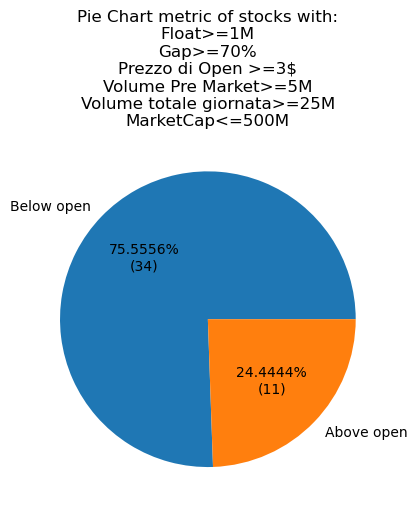

In [37]:
#plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.pie(values, labels=labels, autopct=my_fmt)
plt.title('Pie Chart metric of stocks with:\nFloat>=1M\nGap>=70%\nPrezzo di Open >=3$\nVolume Pre Market>=5M\nVolume totale giornata>=25M\nMarketCap<=500M')


# Question

Out of the 45 times this dynamic occurs, how many times did the price exceed the pre-market high?

To answer this question, I also need pre-market data, which I can obtain thanks to yfinance.

# ABOS

I'm conducting a test first on ABOS to see what happens. As before, I'm interested in data starting from January 1, 2023.

In [38]:
start_date = "2023-01-01"
end_date = "2023-09-06"

In [39]:
abos_df = yf.download("ABOS",start = start_date, end = end_date)
abos_df1h = yf.download("ABOS",start = start_date, end = end_date, interval='1h')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


I calculate the pre-market volume, the gap, and the conditions I need.

In [40]:
volume_pm = abos_df1h.groupby(abos_df1h.index.date).first()['Volume']
abos_df['Gap'] = ((abos_df['Open'] - abos_df['Close'].shift(1)) / abos_df['Close'].shift(1))
abos_df['Volume_pm'] = volume_pm
gap_cond = abos_df['Gap'] >= 0.7
volume_cond = abos_df['Volume'] >= 25e6
volume_pm_cond = abos_df['Volume_pm']>=5e6
open_price_cond = abos_df['Open'] >=3

In [41]:
abos_df_total = abos_df[gap_cond & volume_cond & volume_pm_cond & open_price_cond] 

This is the day when the stock opened with a gap >= 70%.

In [42]:
abos_df_total

,Open,High,Low,Close,Adj Close,Volume,Gap,Volume_pm
Date,,,,,,,,
2023-07-17,11.01,11.31,9.26,9.72,9.72,29215900,0.753185,19406155


I extract the days when all the conditions have been met.

In [43]:
date = abos_df_total.index.strftime("%Y-%m-%d").values

I download the prices for that day with a 1-hour interval to determine the pre-market high.

In [44]:
abos_df1m = yf.download("ABOS",start = date[0], interval='1h',prepost=True)

[*********************100%%**********************]  1 of 1 completed


In [45]:
abos_df1m_day = abos_df1m[abos_df1m.index.strftime("%Y-%m-%d").isin(date)]

I obtain the price of the day of interest (there could be more than one).

In [46]:
abos_df1m_day

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-07-17 04:00:00-04:00,7.2600,9.8200,6.59,8.7000,8.7000,0
2023-07-17 05:00:00-04:00,8.7400,9.2300,8.32,8.9400,8.9400,0
2023-07-17 06:00:00-04:00,8.9100,9.1600,8.25,8.5800,8.5800,0
2023-07-17 07:00:00-04:00,8.5800,9.6900,8.52,9.3600,9.3600,0
2023-07-17 08:00:00-04:00,9.3900,14.0000,7.02,12.1515,12.1515,0
2023-07-17 09:00:00-04:00,12.1800,12.9600,11.00,11.1200,11.1200,0
2023-07-17 09:30:00-04:00,11.0100,11.3099,9.48,9.8000,9.8000,19406155
2023-07-17 10:30:00-04:00,9.7999,9.9500,9.26,9.8850,9.8850,2010923
2023-07-17 11:30:00-04:00,9.8850,10.7500,9.67,10.2300,10.2300,2546515


In [47]:
open_time = datetime.strptime('09:30:00', '%H:%M:%S')
premarket_abos = abos_df1m_day[abos_df1m_day.index.time<open_time.time()]

I obtain the pre-market data (Note: I obtain data for only 1 day, but there could be situations where this dynamic occurs on different days throughout the year, so it is necessary to group by days to determine the pre-market high).

In [48]:
premarket_abos

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-07-17 04:00:00-04:00,7.26,9.82,6.59,8.7000,8.7000,0
2023-07-17 05:00:00-04:00,8.74,9.23,8.32,8.9400,8.9400,0
2023-07-17 06:00:00-04:00,8.91,9.16,8.25,8.5800,8.5800,0
2023-07-17 07:00:00-04:00,8.58,9.69,8.52,9.3600,9.3600,0
2023-07-17 08:00:00-04:00,9.39,14.00,7.02,12.1515,12.1515,0
2023-07-17 09:00:00-04:00,12.18,12.96,11.00,11.1200,11.1200,0


In [49]:
high_pm = premarket_abos.groupby(premarket_abos.index.date)['High'].max()

I obtain the pre-market high.

In [50]:
high_pm

2023-07-17    14.0
Name: High, dtype: float64

In [51]:
abos_df_total['High_pm'] = high_pm
abos_df_total

C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3970827615.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abos_df_total['High_pm'] = high_pm


,Open,High,Low,Close,Adj Close,Volume,Gap,Volume_pm,High_pm
Date,,,,,,,,,
2023-07-17,11.01,11.31,9.26,9.72,9.72,29215900,0.753185,19406155,14.0


I apply this to all tickers where I observe this dynamic.

In [52]:
start_date = "2023-01-01"
end_date = "2023-09-06"
count = 0
tickers_break= []
for ticker in tickers_fav:
    ticker_df = yf.download(ticker,start = start_date, end = end_date)
    ticker_df1h = yf.download(ticker,start = start_date, end = end_date, interval='1h')
    volume_pm = ticker_df1h.groupby(ticker_df1h.index.date).first()['Volume']
    ticker_df['Gap'] = ((ticker_df['Open'] - ticker_df['Close'].shift(1)) / ticker_df['Close'].shift(1))
    ticker_df['Volume_pm'] = volume_pm
    gap_cond = ticker_df['Gap'] >= 0.7
    volume_cond = ticker_df['Volume'] >= 25e6
    volume_pm_cond = ticker_df['Volume_pm']>=5e6
    open_price_cond = ticker_df['Open'] >=3
    ticker_df_total = ticker_df[gap_cond & volume_cond & volume_pm_cond & open_price_cond]
    date = ticker_df_total.index.strftime("%Y-%m-%d").values
    ticker_df1m = yf.download(ticker,start = date[0], interval='1h',prepost=True)
    ticker_df1m_day = ticker_df1m[ticker_df1m.index.strftime("%Y-%m-%d").isin(date)]
    open_time = datetime.strptime('09:30:00', '%H:%M:%S')
    premarket_ticker = ticker_df1m_day[ticker_df1m_day.index.time<open_time.time()]
    high_pm = premarket_ticker.groupby(premarket_ticker.index.date)['High'].max()
    ticker_df_total['High_pm'] = high_pm
    count = count + (ticker_df_total['High'].values > ticker_df_total['High_pm'].values).sum()
    #aumentare count in questo modo mi permette di considerare anche il caso in cui per un ticker si sia verificata la dinamica più di una volta
    if (ticker_df_total['High'].values > ticker_df_total['High_pm'].values).sum() > 0:
        tickers_break.append(ticker)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2534989042.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2534989042.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2534989042.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2534989042.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2534989042.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2534989042.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2534989042.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2534989042.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2534989042.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2534989042.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2534989042.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2534989042.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2534989042.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2534989042.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2534989042.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2534989042.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2534989042.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2534989042.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2534989042.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2534989042.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2534989042.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2534989042.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2534989042.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2534989042.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2534989042.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2534989042.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2534989042.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2534989042.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2534989042.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2534989042.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2534989042.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2534989042.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2534989042.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2534989042.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2534989042.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2534989042.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2534989042.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2534989042.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2534989042.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2534989042.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2534989042.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2534989042.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2534989042.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2534989042.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm


In [53]:
count

27

In [54]:
total

45

In tickers_break ho tutti i tickers di azioni che hanno rotto il massimo di pre apertura.

In [55]:
tickers_break

['ASST',
 'BAER',
 'BBAI',
 'BDTX',
 'BLPH',
 'BMR',
 'BXRX',
 'CDIO',
 'CFRX',
 'CWBR',
 'DRMA',
 'ELEV',
 'ENSC',
 'GDC',
 'HCTI',
 'HOTH',
 'LUCY',
 'MSGM',
 'OCEA',
 'OTRK',
 'QH',
 'SAI',
 'SECO',
 'SNTG',
 'SPRB',
 'UCAR']

# Metric


As we can see, out of 45 times this dynamic occurs, the price breaks the pre-market high 27 times.

In [56]:
def my_fmt(x):
    print(x)
    return '{:.4f}%\n({:.0f})'.format(x, total*x/100)

60.00000238418579
40.00000059604645


Text(0.5, 1.0, 'After opening with a gap greater than 70%, how many times did it break the pre-market high?')

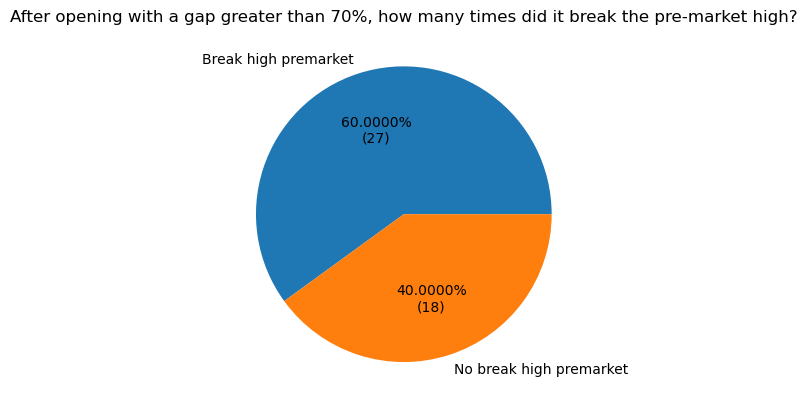

In [57]:
labels = ['Break high premarket', 'No break high premarket']
values = [count, total-count]
plt.pie(values, labels=labels, autopct=my_fmt)
plt.title("After opening with a gap greater than 70%, how many times did it break the pre-market high?")


# Question

Of these 27 times that a stock has exceeded the pre-market high, I consider those that broke it within the first hour.

How many of these closed the day below the open?

# ABOS

I go through the steps from before without commenting.

In [58]:
start_date = "2023-01-01"
end_date = "2023-09-06"

In [59]:
abos_df = yf.download("ABOS",start = start_date, end = end_date)
abos_df1h = yf.download("ABOS",start = start_date, end = end_date, interval='1h')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [60]:
volume_pm = abos_df1h.groupby(abos_df1h.index.date).first()['Volume']
abos_df['Gap'] = ((abos_df['Open'] - abos_df['Close'].shift(1)) / abos_df['Close'].shift(1))
abos_df['Volume_pm'] = volume_pm
gap_cond = abos_df['Gap'] >= 0.7
red_cond = abos_df['Close'] < abos_df['Open']
volume_cond = abos_df['Volume'] >= 25e6
volume_pm_cond = abos_df['Volume_pm']>=5e6
open_price_cond = abos_df['Open'] >=3

In [61]:
abos_df_total = abos_df[gap_cond & volume_cond & volume_pm_cond & open_price_cond ] 

In [62]:
date = abos_df_total.index.strftime("%Y-%m-%d").values

In [63]:
abos_df1m = yf.download("ABOS",start = date[0], interval='1h',prepost=True)

[*********************100%%**********************]  1 of 1 completed


In [64]:
abos_df1m_day = abos_df1m[abos_df1m.index.strftime("%Y-%m-%d").isin(date)]

In [65]:
open_time = datetime.strptime('09:30:00', '%H:%M:%S')
premarket_abos = abos_df1m_day[abos_df1m_day.index.time<open_time.time()]

In [66]:
high_pm = premarket_abos.groupby(premarket_abos.index.date)['High'].max()

In [67]:
abos_df_total['High_pm'] = high_pm
abos_df_total

C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3970827615.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abos_df_total['High_pm'] = high_pm


,Open,High,Low,Close,Adj Close,Volume,Gap,Volume_pm,High_pm
Date,,,,,,,,,
2023-07-17,11.01,11.31,9.26,9.72,9.72,29215900,0.753185,19406155,14.0


# Breaking pre-market high within the first hour.

At this point, I calculate the maximum recorded within the first hour from the opening.

In [68]:
abos_df1m_day[abos_df1m_day.index.time==open_time.time()]

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-07-17 09:30:00-04:00,11.01,11.3099,9.48,9.8,9.8,19406155


In [69]:
high_1h = abos_df1m_day[abos_df1m_day.index.time==open_time.time()]['High'].values

I keep it in array format in case the dynamic happens multiple times for a ticker.

In [70]:
high_1h

array([11.30990028])

In [71]:
abos_df_total['High_1h'] = high_1h
abos_df_total

C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\4211359397.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abos_df_total['High_1h'] = high_1h


,Open,High,Low,Close,Adj Close,Volume,Gap,Volume_pm,High_pm,High_1h
Date,,,,,,,,,,
2023-07-17,11.01,11.31,9.26,9.72,9.72,29215900,0.753185,19406155,14.0,11.3099


I check if the pre-market high was broken within the first hour.

In [72]:
(abos_df_total['High_1h'] > abos_df_total['High_pm']).sum()

0

# I consider all the tickers.

How many times was the maximum broken within the first hour?

In [73]:
start_date = "2023-01-01"
end_date = "2023-09-06"
count_break1h = 0
ticker_break1h = []
for ticker in tickers_break:
    ticker_df = yf.download(ticker,start = start_date, end = end_date)
    ticker_df1h = yf.download(ticker,start = start_date, end = end_date, interval='1h')
    volume_pm = ticker_df1h.groupby(ticker_df1h.index.date).first()['Volume']
    ticker_df['Gap'] = ((ticker_df['Open'] - ticker_df['Close'].shift(1)) / ticker_df['Close'].shift(1))
    ticker_df['Volume_pm'] = volume_pm
    gap_cond = ticker_df['Gap'] >= 0.7
    volume_cond = ticker_df['Volume'] >= 25e6
    volume_pm_cond = ticker_df['Volume_pm']>=5e6
    open_price_cond = ticker_df['Open'] >=3
    ticker_df_total = ticker_df[gap_cond & volume_cond & volume_pm_cond & open_price_cond]
    date = ticker_df_total.index.strftime("%Y-%m-%d").values
    ticker_df1m = yf.download(ticker,start = date[0], interval='1h',prepost=True)
    ticker_df1m_day = ticker_df1m[ticker_df1m.index.strftime("%Y-%m-%d").isin(date)]
    open_time = datetime.strptime('09:30:00', '%H:%M:%S')
    premarket_ticker = ticker_df1m_day[ticker_df1m_day.index.time<open_time.time()]
    high_pm = premarket_ticker.groupby(premarket_ticker.index.date)['High'].max()
    ticker_df_total['High_pm'] = high_pm
    high_1h = ticker_df1m_day[ticker_df1m_day.index.time==open_time.time()]['High'].values
    ticker_df_total['High_1h'] = high_1h
    count_break1h = count_break1h + (ticker_df_total['High_1h'].values > ticker_df_total['High_pm'].values).sum()
    #aumentare count in questo modo mi permette di considerare anche il caso in cui per un ticker si sia verificata la dinamica più di una volta
    if (ticker_df_total['High_1h'].values > ticker_df_total['High_pm'].values).sum() > 0:
        ticker_break1h.append(ticker)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm
C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_1h'] = high_1h


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm
C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_1h'] = high_1h


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm
C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_1h'] = high_1h


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm
C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_1h'] = high_1h


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm
C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_1h'] = high_1h


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm
C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_1h'] = high_1h


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm
C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_1h'] = high_1h


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm
C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_1h'] = high_1h


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm
C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_1h'] = high_1h



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm
C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_1h'] = high_1h


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm
C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_1h'] = high_1h



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm
C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_1h'] = high_1h



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm
C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_1h'] = high_1h



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm
C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_1h'] = high_1h


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm
C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_1h'] = high_1h


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm
C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_1h'] = high_1h


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm
C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_1h'] = high_1h


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm
C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_1h'] = high_1h


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm
C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_1h'] = high_1h


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm
C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_1h'] = high_1h


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm
C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_1h'] = high_1h


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm
C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_1h'] = high_1h


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm
C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_1h'] = high_1h


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm
C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_1h'] = high_1h


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm
C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_1h'] = high_1h


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm
C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\3692525400.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_1h'] = high_1h


In [74]:
count_break1h

24

In [75]:
ticker_break1h

['ASST',
 'BAER',
 'BBAI',
 'BLPH',
 'BMR',
 'BXRX',
 'CDIO',
 'CFRX',
 'CWBR',
 'DRMA',
 'ELEV',
 'ENSC',
 'GDC',
 'HCTI',
 'HOTH',
 'LUCY',
 'MSGM',
 'OCEA',
 'OTRK',
 'QH',
 'SAI',
 'SECO',
 'UCAR']

In [76]:
len(ticker_break1h)

23

As we can see, 24 out of 27 times, the pre-market high was broken within the first hour.

Text(0.5, 1.0, 'How many times was the pre-market high broken within an hour from the opening?')

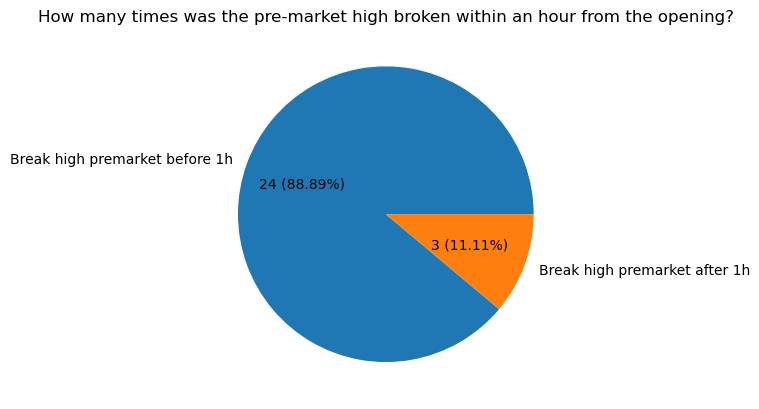

In [77]:
labels = ['Break high premarket before 1h', 'Break high premarket after 1h']
values = [count_break1h, count-count_break1h]
plt.pie(values, labels=labels,autopct=make_autopct(values))
plt.title("How many times was the pre-market high broken within an hour from the opening?")

# Last question


Among all the times the pre-market high was broken within an hour from the opening, how many times did it close below the open?

In [ ]:
start_date = "2023-01-01"
end_date = "2023-09-06"
count_red = 0
for ticker in ticker_break1h:
    ticker_df = yf.download(ticker,start = start_date, end = end_date)
    ticker_df1h = yf.download(ticker,start = start_date, end = end_date, interval='1h')
    volume_pm = ticker_df1h.groupby(ticker_df1h.index.date).first()['Volume']
    ticker_df['Gap'] = ((ticker_df['Open'] - ticker_df['Close'].shift(1)) / ticker_df['Close'].shift(1))
    ticker_df['Volume_pm'] = volume_pm
    gap_cond = ticker_df['Gap'] >= 0.7
    volume_cond = ticker_df['Volume'] >= 25e6
    red_cond = ticker_df['Close'] < ticker_df['Open']
    volume_pm_cond = ticker_df['Volume_pm']>=5e6
    open_price_cond = ticker_df['Open'] >=3
    ticker_df_total = ticker_df[gap_cond & volume_cond & volume_pm_cond & open_price_cond]
    date = ticker_df_total.index.strftime("%Y-%m-%d").values
    ticker_df1m = yf.download(ticker,start = date[0], interval='1h',prepost=True)
    ticker_df1m_day = ticker_df1m[ticker_df1m.index.strftime("%Y-%m-%d").isin(date)]
    open_time = datetime.strptime('09:30:00', '%H:%M:%S')
    premarket_ticker = ticker_df1m_day[ticker_df1m_day.index.time<open_time.time()]
    high_pm = premarket_ticker.groupby(premarket_ticker.index.date)['High'].max()
    ticker_df_total['High_pm'] = high_pm
    high_1h = ticker_df1m_day[ticker_df1m_day.index.time==open_time.time()]['High'].values
    ticker_df_total['High_1h'] = high_1h
    if (ticker_df_total['High_1h'].values > ticker_df_total['High_pm'].values).sum() > 0:
        count_red = count_red + (ticker_df_total['Close'].values < ticker_df_total['Open'].values).sum()
    #aumentare count in questo modo mi permette di considerare anche il caso in cui per un ticker si sia verificata la dinamica più di una volta

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2853001720.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm
C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2853001720.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_1h'] = high_1h


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2853001720.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_pm'] = high_pm
C:\Users\Martin\AppData\Local\Temp\ipykernel_9072\2853001720.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df_total['High_1h'] = high_1h



[*********************100%%**********************]  1 of 1 completed

In [209]:
count_red

18

In [211]:
count_break1h

24

Text(0.5, 1.0, "Delle 24 volte che ha rotto il massimo di pre market nella prima ora, quante volte il prezzo ha chiuso sotto l'apertura?")

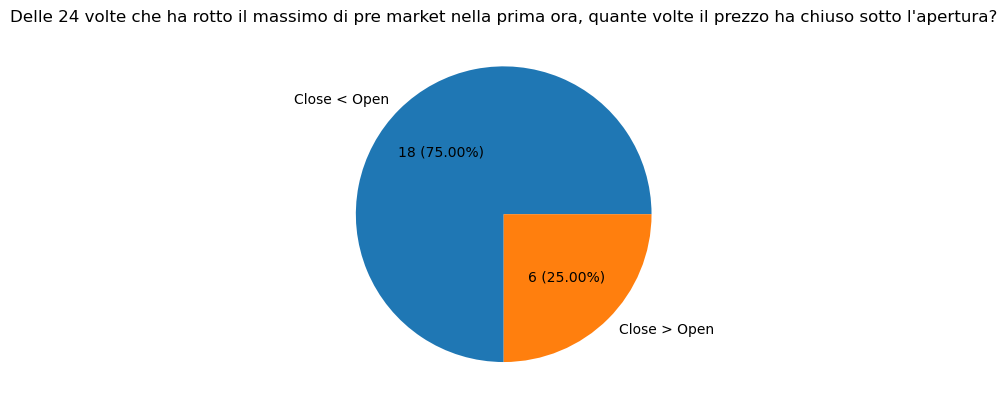

In [214]:
labels = ['Close < Open', 'Close > Open']
values = [count_red, count_break1h-count_red]
plt.pie(values, labels=labels,autopct=make_autopct(values))
plt.title("Delle 24 volte che ha rotto il massimo di pre market nella prima ora, quante volte il prezzo ha chiuso sotto l'apertura?")